In [88]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import _spin_params as spin_pars
from importlib import reload
from _steady_state import a_steady, purcell, a_steady_with_sz, a_steady_hp
from _helper_functions import correct_for_fano, tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left
from _create_pdf import create_spins, create_spins_inhomo_g
from _do_calculation import solve_mbes_general, solve_mbes, solve_mbes_without_cavity, get_pulses_from_cavity_field, solve_mbes_wait, solve_mbes_only_decay, solve_obes
from _mbes import mbes, mbes_soc, mbes_soc_no_cavity, mbes_soc_det, obes_soc
import matplotlib
# matplotlib.use('NbAgg')
import numpy as np
from scipy.stats import logistic
from scipy.optimize import basinhopping
from scipy.special import erf
from scipy import interpolate
from IPython.display import clear_output, Javascript, Markdown, HTML
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.io
import gc
#from qutip import Bloch
from matplotlib.animation import FuncAnimation
import datetime
import time
import random
import mat73
import matplotlib
import _sys_helpers
# _sys_helpers.copy_connection_file()
# matplotlib.pyplot.switch_backend('nbagg')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
gcoll = spin_pars.gcoll
q = spin_pars.q
quali = spin_pars.quali
fr = spin_pars.fr
kappa = np.pi*fr/quali  # HWHM
delta = spin_pars.delta  # detuning cavity to spin central frequency ws-wc
deltac = spin_pars.deltac  # detuning drive to cavity wc-wp
gperp = spin_pars.gperp  # HWHM
gpar = spin_pars.gpar  # 0.001 #HWHM
gammaq = spin_pars.gammaq
nbins = spin_pars.nbins  # 701#5000#20
g_number = spin_pars.g_number  # how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
nreal = spin_pars.nreal
spin_dist_width = spin_pars.spin_dist_width
print(kappa)

5.280491375196432


In [11]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulse


def pulse_rwa_gauss(t, args):
    wgrund = args[0]
    fcomps = args[1]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund

    width = 2*tend/(nfcomps+5)
    t0 = 3*width/2
    pulse = 0
    for i in range(len(fcomps)):
        pulse += fcomps[i]*np.exp(-4*(t-t0)**2*np.log(2)/width**2)
        t0 += 0.5*width
    pulse *= logistic.cdf(t, loc=0.01, scale=.002) * \
        (1-logistic.cdf(t, loc=tend-0.01, scale=.002))
    pulse *= 0.46971947398573455
    return pulse


def pulse_rwa_gauss_const(t, args):
    wgrund = args[0]
    fcomps = args[1]
    maxampl = args[2]
    tend = np.pi/wgrund

    spline = 0
    for i in range(len(fcomps)):
        spline += (fcomps[i])*np.sin((i+1)*wgrund*t)
    pulsei = 0
    pulseq = 0
    pulse = 0
    pulse = maxampl*logistic.cdf(t, loc=0.02, scale=0.004) * \
        (1-logistic.cdf(t, loc=tend-0.02, scale=0.004))

    pulsei = pulse*np.cos(spline)
    pulseq = pulse*np.sin(spline)

    return pulsei, pulseq

In [12]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)


x_start = 5
x_stop = 20  # µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

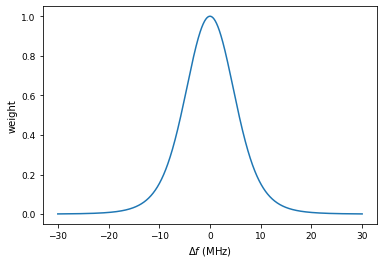

Cooperativity is: 5.698822


In [13]:
plt.close('all')
matplotlib.interactive(False)
spins, gs, pdf = create_spins_inhomo_g(
    gcoll, g_list, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True, spin_width=spin_dist_width)
plt.figure()
plt.plot(spins[:len(pdf)], pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight')
plt.show()
# %qtconsole
coop = gcoll**2/kappa*np.sum(pdf/(gperp+1j*2*np.pi*spins))
print("Cooperativity is: %f" % coop.real)
# %qtconsole

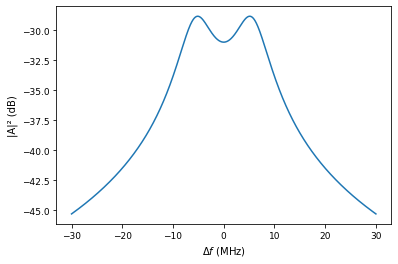

In [14]:
plt.close('all')
matplotlib.interactive(False)

initsteady = (0.001, 0.001)
fstart = 30
deltaarr = np.linspace(-fstart*2*np.pi, fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)')
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
plt.show()
# %qtconsole
#deltaarr[find(losasteady == max(losasteady))]/2/pi

# SOC pulses

In [15]:
pumptime = 50e-3  # 5*np.pi/gcoll
decaytime = 1000e-3
dt = 0.0005
numsteps = int(pumptime/dt)
tlist = np.arange(0, pumptime+dt, dt)
tlistdecay = np.arange(0, decaytime+dt, dt)


# test time it takes to calculate


init = np.ones(len(spins)*2+1)*(-1)
init[0] = 0
init[1::2] = 0
# %qtconsole

In [89]:
filepath = "%s/%s" % (spin_pars.folder, spin_pars.reference_trace)

exp = {}
traceidx = 0
try:
    data = mat73.loadmat(filepath)
except TypeError:
    data = scipy.io.loadmat(filepath, simplify_cells=True)
data = data['trace_avg_detuned']
#data = data['tr'][27]
imagpart = data['imagpart']
realpart = data['realpart']
freqStart = data['freqStart']
freqStop = data['freqStop']
numPoints = data['numPoints']

omegap = np.linspace(freqStart, freqStop, numPoints)*2*np.pi*1e-6
freqs = (omegap/2/np.pi -
         1e-6*(freqStart+freqStop)/2)
power = np.squeeze(imagpart**2+realpart**2)

phi = spin_pars.phi
offset_phi = spin_pars.phi_offset
dt = spin_pars.dt
offset = spin_pars.offset
corrected_real, corrected_imag = correct_for_fano(
    omegap, realpart, imagpart, phi, dt, offset, offset_phi)
power_corrected = corrected_real**2+corrected_imag**2

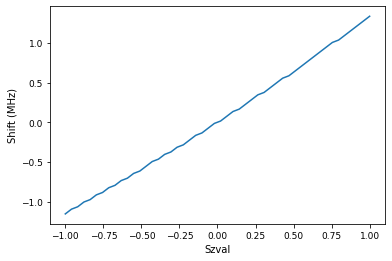

In [74]:
detuning_spins_cav = -18.9
szvals = np.linspace(-1, 1, 50)
maxids = np.zeros(np.shape(szvals), dtype=int)
plt.close('all')
matplotlib.interactive(False)

etasteady = 0.00001
fstart = 30
deltaarrdisp = np.linspace(-fstart*2*np.pi, fstart*2*np.pi, 2000)
losasteadydisp = np.zeros(np.shape(deltaarrdisp))
for j, szv in enumerate(szvals):
    for i, delt in enumerate(deltaarrdisp):
        ar, ai = a_steady_with_sz(etasteady, delt, gs, spins+detuning_spins_cav,
                                  gpar, gperp, kappa, np.ones(len(spins))*(szv))
        losasteadydisp[i] = ai**2+ar**2
    maxids[j] = int(np.where(losasteadydisp == max(losasteadydisp))[0])
fig = plt.figure()

plt.plot(szvals, deltaarrdisp[maxids]/2/np.pi)

plt.xlabel('Szval')
plt.ylabel('Shift (MHz)')

plt.show()
# %qtconsole
#deltaarr[find(losasteady == max(losasteady))]/2/pi

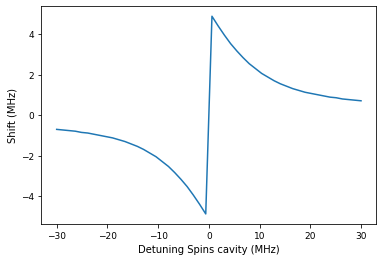

In [96]:
detuning_spins_cav2 = np.linspace(-30, 30, 50)
maxids = np.zeros(np.shape(detuning_spins_cav2), dtype=int)
plt.close('all')
matplotlib.interactive(False)

etasteady = 0.00001
fstart = 30
deltaarrdisp2 = np.linspace(-fstart*2*np.pi, fstart*2*np.pi, 2000)
losasteadydisp2 = np.zeros((len(deltaarrdisp2), len(detuning_spins_cav2)))
for j, detv in enumerate(detuning_spins_cav2):
    for i, delt in enumerate(deltaarrdisp):
        ar, ai = a_steady_hp(etasteady, delt, gs, spins +
                             detv, gpar, gperp, kappa, init)
        losasteadydisp2[i, j] = ai**2+ar**2
    maxids[j] = int(np.where(losasteadydisp2[:, j] ==
                    max(losasteadydisp2[:, j]))[0])
fig = plt.figure()

plt.plot(detuning_spins_cav2, deltaarrdisp2[maxids]/2/np.pi)

plt.xlabel('Detuning Spins cavity (MHz)')
plt.ylabel('Shift (MHz)')

plt.show()

#deltaarr[find(losasteady == max(losasteady))]/2/pi

In [220]:
def fitfuncall(freqs, ampl, detuning, gammaq):
    losasteady = np.zeros(np.shape(freqs))
    spins2, gs2, pdf2 = create_spins_inhomo_g(
        gcoll, g_list, q, delta+detuning*2*np.pi, gammaq, nbins, holes=False, inhomo=True, hyperfine=True, spin_width=spin_dist_width)
    for i, delt in enumerate(freqs):
        ar, ai = a_steady_hp(etasteady, delt*2*np.pi, gs2,
                             spins2, gpar, gperp, kappa, init)
        losasteady[i] = ai**2+ar**2
    losasteady *= ampl/max(abs(losasteady))
    return losasteady

Detuning is -22.0562MHz
Linewidth is now 17.08MHz instead of 10.11MHz


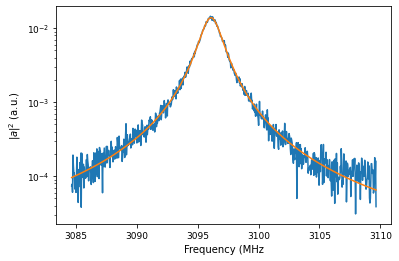

In [229]:
plt.close('all')
matplotlib.interactive(False)

freqs_dat = omegap/2/np.pi-fr
p0 = [max(power_corrected), -20, gammaq]
popt, pcov = scipy.optimize.curve_fit(
    fitfuncall, freqs_dat, power_corrected.ravel(), p0=p0)


plt.semilogy(omegap/2/np.pi, power_corrected)
plt.plot(omegap/2/np.pi, fitfuncall(freqs_dat, *popt))
plt.xlabel("Frequency (MHz")
plt.ylabel("$|a|^2$ (a.u.)")
print("Detuning is %.4fMHz" % popt[1])
print("Linewidth is now %.2fMHz instead of %.2fMHz" %
      (popt[2]/2/np.pi, gammaq/2/np.pi))
plt.show()